<a href="https://colab.research.google.com/github/cbadenes/notebooks/blob/main/probabilistic_topic_models/Dynamic_Topic_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from collections import Counter

# Para procesamiento de texto
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

# Para modelado de tópicos
from gensim.models import LdaSeqModel
from gensim.corpora import Dictionary

# Configuración inicial
plt.rcParams.update({
    'figure.figsize': (12, 6),
    'axes.grid': True,
    'grid.alpha': 0.3,
    'axes.spines.top': False,
    'axes.spines.right': False
})

# Descargar recursos necesarios de NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [8]:
# Cargar dataset
df = pd.read_json('News_Category_Dataset_v3.json', lines=True)

# Tomar un subset manejable (200 noticias de 2015-2016)
mask = (df['date'] >= '2015-01-01') & (df['date'] <= '2016-12-31')
df = df[mask].sample(n=200, random_state=42)

# Convertir fechas a datetime y ordenar
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

print("Dimensiones del dataset:", df.shape)
print("\nRango temporal:", df['date'].min(), "-", df['date'].max())
print("\nCategorías disponibles:", df['category'].unique())

Dimensiones del dataset: (500, 6)

Rango temporal: 2015-01-02 00:00:00 - 2016-12-30 00:00:00

Categorías disponibles: ['POLITICS' 'ENTERTAINMENT' 'BUSINESS' 'CRIME' 'RELIGION' 'GREEN'
 'PARENTS' 'ARTS' 'FIFTY' 'STYLE' 'GOOD NEWS' 'EDUCATION' 'SPORTS'
 'QUEER VOICES' 'WORLDPOST' 'HEALTHY LIVING' 'IMPACT' 'WEIRD NEWS' 'WOMEN'
 'COMEDY' 'TRAVEL' 'TASTE' 'MEDIA' 'SCIENCE' 'BLACK VOICES'
 'ARTS & CULTURE' 'THE WORLDPOST' 'COLLEGE' 'TECH' 'LATINO VOICES']


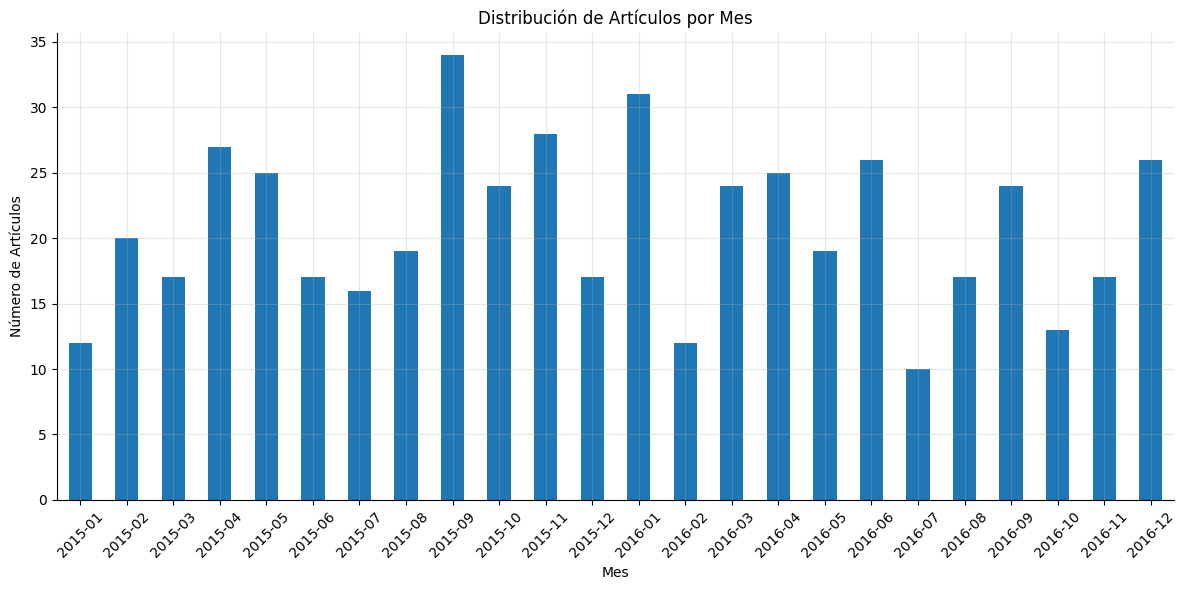

In [9]:
# Visualización de distribución temporal
plt.figure(figsize=(12, 6))
df['date'].dt.to_period('M').value_counts().sort_index().plot(kind='bar')
plt.title('Distribución de Artículos por Mes')
plt.xlabel('Mes')
plt.ylabel('Número de Artículos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
def preprocess_text(text):
    """
    Preprocesa el texto para análisis de tópicos
    """
    # Inicializar herramientas
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    # Convertir a minúsculas
    text = text.lower()

    # Eliminar caracteres especiales
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenizar
    tokens = word_tokenize(text)

    # Eliminar stopwords y lematizar
    tokens = [lemmatizer.lemmatize(token) for token in tokens
             if token not in stop_words and len(token) > 2]

    return tokens

# Combinar título y descripción para el análisis
df['text'] = df['headline'] + ' ' + df['short_description']

# Aplicar preprocesamiento
df['processed_text'] = df['text'].apply(preprocess_text)

# Verificar el preprocesamiento
print("\nEjemplo de preprocesamiento:")
print("Original:", df['text'].iloc[0])
print("Procesado:", df['processed_text'].iloc[0])


Ejemplo de preprocesamiento:
Original: Know When to Fold 'Em Barack Obama reportedly takes pride in his skill as a card player. Poker is the prime game of politics and politicians. The president's record suggests that he is something less than its master. There is only one group of players whom he beats regularly -- the "liberals" whose gambling instincts have been honed in endless games of rainy-day Scrabble.
Procesado: ['know', 'fold', 'barack', 'obama', 'reportedly', 'take', 'pride', 'skill', 'card', 'player', 'poker', 'prime', 'game', 'politics', 'politician', 'president', 'record', 'suggests', 'something', 'less', 'master', 'one', 'group', 'player', 'beat', 'regularly', 'liberal', 'whose', 'gambling', 'instinct', 'honed', 'endless', 'game', 'rainyday', 'scrabble']


In [11]:
# Crear diccionario
dictionary = Dictionary(df['processed_text'])

# Filtrar términos poco frecuentes o muy comunes
dictionary.filter_extremes(no_below=5, no_above=0.5)
print("\nTamaño del vocabulario:", len(dictionary))

# Crear corpus
corpus = [dictionary.doc2bow(doc) for doc in df['processed_text']]

# Preparar time_slices (documentos por mes)
df['month'] = df['date'].dt.to_period('M')
time_slices = df.groupby('month').size().tolist()
print("\nNúmero de periodos temporales:", len(time_slices))



Tamaño del vocabulario: 275

Número de periodos temporales: 24


In [ ]:
# Configurar y entrenar modelo
num_topics = 3  # Número de tópicos a detectar
chain_variance = 0.100  # Controla la suavidad de la evolución temporal

dtm = LdaSeqModel(
    corpus=corpus,
    time_slice=time_slices,
    num_topics=num_topics,
    id2word=dictionary,
    chain_variance=chain_variance,
    passes=10
)


/usr/local/lib/python3.10/dist-packages/gensim/models/ldaseqmodel.py:1480: RuntimeWarning: invalid value encountered in scalar divide
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
/usr/local/lib/python3.10/dist-packages/gensim/models/ldaseqmodel.py:298: RuntimeWarning: divide by zero encountered in scalar divide
  convergence = np.fabs((bound - old_bound) / old_bound)
/usr/local/lib/python3.10/dist-packages/gensim/models/ldaseqmodel.py:1480: RuntimeWarning: invalid value encountered in scalar divide
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
/usr/local/lib/python3.10/dist-packages/gensim/models/ldaseqmodel.py:1480: RuntimeWarning: invalid value encountered in scalar divide
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
/usr/local/lib/python3.10/dist-packages/gensim/models/ldaseqmodel.py:1480: RuntimeWarning: invalid value encountered in scalar divide
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
/usr/local/li

In [ ]:
def print_topic_evolution(model, periods=None):
    """
    Imprime la evolución de tópicos a lo largo del tiempo
    """
    num_time_slices = len(time_slices)
    for t in range(num_time_slices):
        print(f"\nPeríodo {t}:")
        for topic in range(model.num_topics):
            # La nueva sintaxis no usa el parámetro 'topics'
            top_terms = model.print_topics(time=t)[topic]
            print(f"Tópico {topic}: {top_terms[:5]}")

# Mostrar evolución de tópicos
print_topic_evolution(dtm)


Período 0:
Tópico 0: [('time', 0.09507243824636157), ('day', 0.054652788447331), ('something', 0.05148854712967132), ('youre', 0.04949170399979991), ('need', 0.046358506032829004)]
Tópico 1: [('president', 0.09183870776129575), ('series', 0.08589603522150253), ('state', 0.05305338903815731), ('said', 0.05217759382308835), ('home', 0.047785451071662495)]
Tópico 2: [('one', 0.11025298144259321), ('would', 0.08165746365365385), ('year', 0.08158718557904554), ('even', 0.06156715414838264), ('right', 0.050834054198663985)]

Período 1:
Tópico 0: [('time', 0.08938807938498344), ('day', 0.05545935821394854), ('something', 0.05221451328594464), ('youre', 0.05016754736148363), ('need', 0.04695908583690584)]
Tópico 1: [('president', 0.0944070932346202), ('series', 0.08813670874933971), ('state', 0.048850198020982026), ('home', 0.04844373005334748), ('said', 0.04793271239598993)]
Tópico 2: [('one', 0.09914213144789), ('would', 0.08784079742761083), ('year', 0.07244054315457094), ('even', 0.059081

# 8. EJERCICIOS PROPUESTOS
# -----------------------

"""
1. Ajuste de Parámetros:
   - Modifica num_topics y observa los cambios
   - Experimenta con diferentes chain_variance
   - Prueba diferentes granularidades temporales

2. Análisis Temporal:
   - ¿Cómo cambian los tópicos mes a mes?
   - ¿Hay eventos específicos que afecten los tópicos?
   - ¿Qué categorías son más estables/variables?

3. Visualizaciones Adicionales:
   - Crea un heatmap de evolución temporal
   - Visualiza la similitud entre tópicos
   - Grafica la evolución de categorías específicas

4. Preprocesamiento:
   - Añade/elimina stopwords
   - Incluye bigramas
   - Modifica los filtros de frecuencia
"""

In [ ]:
# Guardar el modelo
dtm.save('dtm_model')

# Exportar tópicos por periodo a un CSV
topics_over_time = {}
num_time_slices = len(time_slices)

for t in range(num_time_slices):
    # Obtener tópicos para este período
    topics = dtm.print_topics(time=t)

    # Guardar cada tópico
    period_topics = {}
    for topic_id, topic_terms in enumerate(topics):
        period_topics[f'Topic_{topic_id}'] = topic_terms[1]  # topic_terms[1] contiene los términos

    topics_over_time[t] = period_topics

# Convertir a DataFrame
topics_df = pd.DataFrame.from_dict(topics_over_time, orient='index')

# Guardar en CSV
topics_df.to_csv('topics_evolution.csv')

print("\nResultados guardados:")
print("- Modelo: dtm_model")
print("- Evolución de tópicos: topics_evolution.csv")


Resultados guardados:
- Modelo: dtm_model
- Evolución de tópicos: topics_evolution.csv
